# DengAI: Predicting Disease Spread
<h4>This project is being hosted by DrivenData.org with data input from NOAA and PERISANN. The purpose of this projet is to predict where the next outbreak of Dengue fever will be. The areas of predictions are San Juan, Puerto Rico and Iquitos, Peru. The task is to predict the number of dengue cases each week (in each location) based on environmental variables describing changes in temperature, precipitation, vegetation, and more.</h4>
<h4> This project will aim to predict the next outbreak through efficient EDA, feature engineering, regression modeling,seasonal decomposition and validating results through mean square error.</h4>
<img src='Map.png'>

## 1. Data Dictionary
 Below is a data dictionary describing what each column in the dataframe entitles. The columns will be analyzed and determined if any null values, measurement changes, imputing, removal, dropping, combining, or feature engineering are required in order for the data to be as clean and accurate as possible.

<h4>1.City and date indicators</h4><ul>
   <li><b>city</b> – City abbreviations: sj for San Juan and iq for Iquitos</li>
   <li><b>week_start_date</b> – Date given in yyyy-mm-dd format</li>

<h4>2.NOAA's GHCN daily climate data weather station measurements</h4>
   <li><b>station_max_temp_c</b> – Maximum temperature</li>
   <li><b>station_min_temp_c</b> – Minimum temperature</li>
   <li><b>station_avg_temp_c</b> – Average temperature</li>
   <li><b>station_precip_mm</b> – Total precipitation</li>
   <li><b> station_diur_temp_rng_c</b> – Diurnal temperature range

<h4>3.PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)</h4>
  <li><b> precipitation_amt_mm</b> – Total precipitation</li>

<h4>4.NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)</h4>
  <li><b> reanalysis_sat_precip_amt_mm</b> – Total precipitation</li>
  <li><b> reanalysis_dew_point_temp_k</b>– Mean dew point temperature</li>
  <li><b> reanalysis_air_temp_k</b> – Mean air temperature</li>
  <li><b> reanalysis_relative_humidity_percent</b> – Mean relative humidity</li>
  <li><b> reanalysis_specific_humidity_g_per_kg</b> – Mean specific humidity</li>
  <li><b> reanalysis_precip_amt_kg_per_m2</b> – Total precipitation</li>
  <li><b> reanalysis_max_air_temp_k</b> – Maximum air temperature</li>
  <li><b> reanalysis_min_air_temp_k</b> – Minimum air temperature</li>
  <li><b> reanalysis_avg_temp_k</b> – Average air temperature</li>
  <li><b> reanalysis_tdtr_k</b> – Diurnal temperature range</li>

<h4>5.Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements</h4>
  <li><b>ndvi_se</b> – Pixel southeast of city centroid</li>
  <li><b>ndvi_sw</b> – Pixel southwest of city centroid</li>
  <li><b>ndvi_ne</b> – Pixel northeast of city centroid</li>
  <li><b>ndvi_nw</b> – Pixel northwest of city centroid</li></ul>

### Load Files as .CSV

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from scipy.stats import mode
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.svm import LinearSVR 
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\emmag\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Loaded dengue csv files
dengue = pd.read_csv('dengue_features_train.csv')
dengue_labels = pd.read_csv ('dengue_labels_train.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Feature Engineering

In [3]:
# First issue: changed the cities to 0 and 1 in case classification modeling is done.
city_cat=dengue['city'].map(lambda x: 1 if x == 'sj' else 0)

In [4]:
# Added the new column to the dataset. I don't want to overwrite the city column since it is an intergal part of the preidcting
# model. So now the city column is kept and can be worked with while the new column can be used for classification purposes.
# Might be able to do KNN  or another clustering method to see if outbreaks can be predicted. Will look further into this idea
# and the possibilities espiecally since there seem 
dengue['city_cat']=dengue['city'].map(lambda x: 1 if x == 'sj' else 0)

In [5]:
# New dataset with city added as a binary category
dengue.head(10)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city_cat
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,1
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,1
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,1
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,1
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,1
5,sj,1990,23,6/4/1990,NaN,0.174850,0.254314,0.181743,9.58,299.630000,299.764286,295.851429,302.4,298.1,26.49,79.891429,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,1
6,sj,1990,24,6/11/1990,0.112900,0.092800,0.205071,0.210271,3.48,299.207143,299.221429,295.865714,301.3,297.7,38.60,82.000000,3.48,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7,1
7,sj,1990,25,6/18/1990,0.072500,0.072500,0.151471,0.133029,151.12,299.591429,299.528571,296.531429,300.6,298.4,30.00,83.375714,151.12,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1,1
8,sj,1990,26,6/25/1990,0.102450,0.146175,0.125571,0.123600,19.32,299.578571,299.557143,296.378571,302.1,297.7,37.51,82.768571,19.32,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1,1
9,sj,1990,27,7/2/1990,NaN,0.121550,0.160683,0.202567,14.41,300.154286,300.278571,296.651429,302.3,298.7,28.40,81.281429,14.41,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1,1


In [6]:
# Second issue: dealing with tempertaure conversation from C to F.
def celsius_to_fahren(temp_celsius):
    temp_fahren = (temp_celsius *1.8) + 32
    return temp_fahren

In [7]:
dengue['station_avg_temp_f'] = celsius_to_fahren(dengue.station_avg_temp_c)
dengue.drop(['station_avg_temp_c'], axis = 1, inplace=True)

In [8]:
dengue['station_max_temp_f'] = celsius_to_fahren(dengue.station_max_temp_c)
dengue.drop(['station_max_temp_c'], axis = 1, inplace=True)

In [9]:
dengue['station_min_temp_f'] = celsius_to_fahren(dengue.station_min_temp_c)
dengue.drop(['station_min_temp_c'], axis = 1, inplace=True)

In [10]:
dengue['station_diur_temp_rng_f'] = celsius_to_fahren(dengue.station_diur_temp_rng_c)
dengue.drop(['station_diur_temp_rng_c'], axis = 1, inplace=True)

In [11]:
# New dataset with tempertaures converted to Fahrenheit
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_precip_mm,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,16.0,1,77.797143,84.92,68.00,44.420000
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,8.6,1,80.085714,89.06,71.96,43.468571
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,41.4,1,80.085714,89.96,73.04,43.674286
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,4.0,1,81.448571,91.94,73.94,44.188571
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,5.8,1,84.097143,95.00,75.02,48.868571


In [12]:
# Third issue: convert mm to inches
def mm_to_inch(mm):
    inch = mm/25.4
    return inch

In [13]:
dengue['precipitation_amt_inch'] = mm_to_inch(dengue.precipitation_amt_mm)
dengue.drop(['precipitation_amt_mm'], axis = 1, inplace = True)

In [14]:
dengue['reanalysis_sat_precip_amt_inch'] = mm_to_inch(dengue.reanalysis_sat_precip_amt_mm)
dengue.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace = True)

In [15]:
dengue['station_precip_inch'] = mm_to_inch(dengue.station_precip_mm)
dengue.drop(['station_precip_mm'], axis = 1, inplace = True)

In [16]:
# New dataset with converted mm to inches
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,14.012857,2.628571,1,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,15.372857,2.371429,1,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,16.848571,2.300000,1,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,16.672857,2.428571,1,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,17.210000,3.014286,1,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346


In [17]:
# Fourth issue: converted Kelvin to Fahrenheit
def kelvin_to_fahren(temp_kelvin):
    temp_fahren = (temp_kelvin *1.8) - 459.67
    return temp_fahren  

In [18]:
dengue['reanalysis_min_air_temp_f'] = kelvin_to_fahren(dengue.reanalysis_min_air_temp_k)
dengue.drop(['reanalysis_min_air_temp_k'], axis = 1, inplace = True)

In [19]:
dengue['reanalysis_air_temp_f'] = kelvin_to_fahren(dengue.reanalysis_air_temp_k)
dengue.drop(['reanalysis_air_temp_k'], axis = 1, inplace = True)

In [20]:
dengue['reanalysis_avg_temp_f'] = kelvin_to_fahren(dengue.reanalysis_avg_temp_k)
dengue.drop(['reanalysis_avg_temp_k'], axis = 1, inplace = True)

In [21]:
dengue['reanalysis_dew_point_temp_f'] = kelvin_to_fahren(dengue.reanalysis_dew_point_temp_k)
dengue.drop(['reanalysis_dew_point_temp_k'], axis = 1, inplace = True)

In [22]:
dengue['reanalysis_max_air_temp_f'] = kelvin_to_fahren(dengue.reanalysis_max_air_temp_k)
dengue.drop(['reanalysis_max_air_temp_k'], axis = 1, inplace = True)

In [23]:
dengue['reanalysis_tdtr_f'] = kelvin_to_fahren(dengue.reanalysis_tdtr_k)
dengue.drop(['reanalysis_tdtr_k'], axis = 1, inplace = True)

In [24]:
# New dataset with Kelvin converted to Fahrenheit
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,14.012857,1,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,15.372857,1,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,16.848571,1,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,16.672857,1,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,17.210000,1,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286


In [25]:
# Fifth issue: Change date from object to datetime
dengue['week_start_date']=pd.to_datetime(dengue.week_start_date)

In [26]:
# New dataset with date converted to datetime instead of an object
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,14.012857,1,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,15.372857,1,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,16.848571,1,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,16.672857,1,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,17.210000,1,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286


In [27]:
# Sixth issue: kilogram per square meter to pound per square inch
def kgm2_to_lbin2(kg_per_m2):
    lb_per_in2 = (kg_per_m2 *.00142233)
    return lb_per_in2

In [28]:
dengue['reanalysis_precip_amt_lb_per_in2'] = kgm2_to_lbin2(dengue.reanalysis_precip_amt_kg_per_m2)
dengue.drop(['reanalysis_precip_amt_kg_per_m2'], axis = 1, inplace = True)

In [29]:
# New dataset with kilograms per square meters converted to pound per square inch
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,73.365714,14.012857,1,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571,0.045515
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,77.368571,15.372857,1,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429,0.025517
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,82.052857,16.848571,1,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000,0.037123
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,80.337143,16.672857,1,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571,0.019770
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,80.460000,17.210000,1,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286,0.017352


In [30]:
# Seventh issue: gram per kilogram to grains per pound
def gperkg_to_grperlb(g_per_kg):
    gr_per_lb = (g_per_kg * 7)
    return gr_per_lb

In [31]:
dengue['reanalysis_specific_humidity_gr_per_lb'] = gperkg_to_grperlb(dengue.reanalysis_specific_humidity_g_per_kg)
dengue.drop(['reanalysis_specific_humidity_g_per_kg'], axis = 1, inplace = True)

In [32]:
# New dataset with converted grams per kilograms to grain per pound
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,73.365714,1,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571,0.045515,98.09
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,77.368571,1,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429,0.025517,107.61
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,82.052857,1,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000,0.037123,117.94
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,80.337143,1,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571,0.019770,116.71
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,80.460000,1,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286,0.017352,120.47


#### Summary of results
<h4>I made a judgement call to convert all the measurements from metrics to the US Standard system. I know in the end, once the data is normalizaled through sclaing it doesn't matter but I had very specfic reasons for doing these converstions. I wanted to have the data in a more understabdable format for myself. I'm going to be preforming deep analytical and stastical anaylais on it and I want it to be in measuremnets that I can comprehend. I also, wanted to show that I understand the concepts behind creating codes through definitions and how to convert different measurments gto different measurements.</h4>
<h4>The data is all converted, so I will be moving on to exploring the data, replacing,deleting null values, examining the data for duplications, conducting data comparisons between specific features which I sispect have correlations, and deleting features that aren't needed.</h4>
<h4>Later I will be creating new feature columns based on climate and environmental factors, in the hopes of better predicting outbreak areas.</h4>

## 3. Exploratory Data Analysis

In [33]:
# Brief look at dengue feature .csv. 1455 rows with 25 columns.
dengue.head(20)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,73.365714,1,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571,0.045515,98.09
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,77.368571,1,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429,0.025517,107.61
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,82.052857,1,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000,0.037123,117.94
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,80.337143,1,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571,0.019770,116.71
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,80.460000,1,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286,0.017352,120.47
5,sj,1990,23,1990-06-04,NaN,0.174850,0.254314,0.181743,79.891429,1,82.605714,93.92,75.02,44.497143,0.377165,0.377165,1.539370,76.91,79.664000,79.905714,72.862571,84.65,-455.890000,0.037678,120.49
6,sj,1990,24,1990-06-11,0.112900,0.092800,0.205071,0.210271,82.000000,1,81.345714,89.96,73.94,44.188571,0.137008,0.137008,1.169291,76.19,78.902857,78.928571,72.888286,82.67,-455.992857,0.054902,120.64
7,sj,1990,25,1990-06-18,0.072500,0.072500,0.151471,0.133029,83.375714,1,83.068571,93.02,73.04,45.834286,5.949606,5.949606,0.830709,77.45,79.594571,79.481429,74.086571,81.41,-456.841429,0.042670,125.84
8,sj,1990,26,1990-06-25,0.102450,0.146175,0.125571,0.123600,82.768571,1,82.991429,93.02,73.04,45.294286,0.760630,0.760630,0.830709,76.19,79.571429,79.532857,73.811429,84.11,-456.275714,0.053352,124.53
9,sj,1990,27,1990-07-02,NaN,0.121550,0.160683,0.202567,81.281429,1,82.991429,93.02,75.92,43.725714,0.567323,0.567323,0.043307,77.99,80.607714,80.831429,74.302571,84.47,-456.044286,0.040394,126.50


In [34]:
# Duplicate columns expect for total_cases. 
dengue_labels.head(10)

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
5,sj,1990,23,2
6,sj,1990,24,4
7,sj,1990,25,5
8,sj,1990,26,10
9,sj,1990,27,6


In [35]:
# Joined the two datsets so the total_cases would be part of the main dataset.
#dengue.merge(dengue_labels['total_cases']

#dengue_new = dengue.append(dengue_labels['total_cases'], axis=1)

#result = pd.merge(dengue,dengue_labels[['total_cases']], on='weekofyear')
#result.head()

#pd.merge(dengue, dengue_labels[['total_cases']], how='right', on='weekofyear')

dengue_new= dengue.join(dengue_labels[['total_cases']], how='right')

In [36]:
dengue =(dengue.join(dengue_labels[['total_cases']], how='right'))

In [37]:
# There seem to be a number of null values that need to be explored. Most of the data seem to be int or floats which is good.
# Week start date is an object, not sure if that data type will have to be changed. The week of the year is an int so there maybe
# no need to, but I'll have to remember that this may cause an issue later on. City is also an object, if I want to go the
# the clasification route and try and predict total cases that way I made need to change the type so it can be dummizied. That's
# another option to look into.
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 26 columns):
city                                      1456 non-null object
year                                      1456 non-null int64
weekofyear                                1456 non-null int64
week_start_date                           1456 non-null datetime64[ns]
ndvi_ne                                   1262 non-null float64
ndvi_nw                                   1404 non-null float64
ndvi_se                                   1434 non-null float64
ndvi_sw                                   1434 non-null float64
reanalysis_relative_humidity_percent      1446 non-null float64
city_cat                                  1456 non-null int64
station_avg_temp_f                        1413 non-null float64
station_max_temp_f                        1436 non-null float64
station_min_temp_f                        1442 non-null float64
station_diur_temp_rng_f                   1413 non-null float

In [38]:
# NaN values that have to be looked at and determined whether to be dropped or imputered/dummizied.
dengue.isnull().sum()[dengue.isnull().sum()>0]

ndvi_ne                                   194
ndvi_nw                                    52
ndvi_se                                    22
ndvi_sw                                    22
reanalysis_relative_humidity_percent       10
station_avg_temp_f                         43
station_max_temp_f                         20
station_min_temp_f                         14
station_diur_temp_rng_f                    43
precipitation_amt_inch                     13
reanalysis_sat_precip_amt_inch             13
station_precip_inch                        22
reanalysis_min_air_temp_f                  10
reanalysis_air_temp_f                      10
reanalysis_avg_temp_f                      10
reanalysis_dew_point_temp_f                10
reanalysis_max_air_temp_f                  10
reanalysis_tdtr_f                          10
reanalysis_precip_amt_lb_per_in2           10
reanalysis_specific_humidity_gr_per_lb     10
dtype: int64

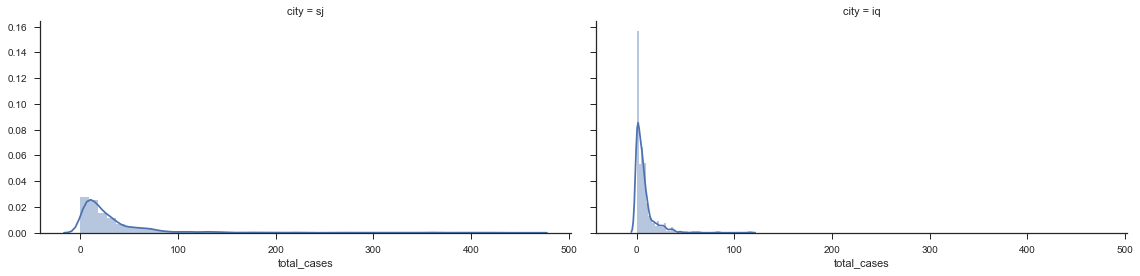

In [39]:
# There definitly seems to be a higher total amount of cases in a certain time period Peru vs Puerto Rico
# but Puerto Rico is more consistent in its amount  of cases. It seems to be Puero has a certain time of year that it peaks while
# Puerto Rico has cases all year but at a low level.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect = 2, size = 4)
g.map(sns.distplot, "total_cases")
None

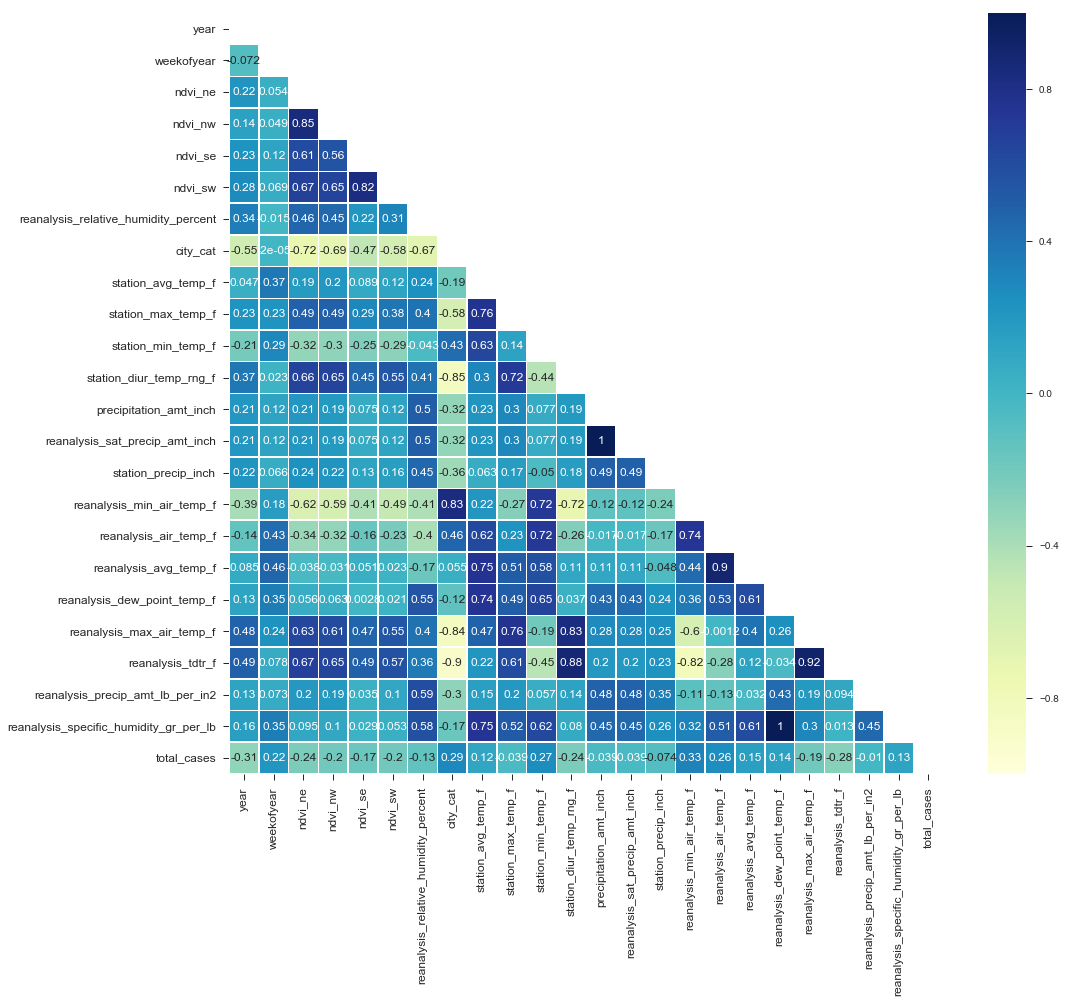

In [40]:
corr = dengue.corr()

fig, ax = plt.subplots(figsize=(16,14))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="YlGnBu",  linewidths=.5)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

##### Analysis of Heatmap
<h4>First looking at the heatmap in general, there are some very strong correlations between reanalysis specific humidity and reanalysis of dew point also between reanalysis saturated precipitation amount and preceipitation amount which leads me to believe there is eitehr mutlcolinearity here or these columns are duplicate values. Theses will be examined to determine if either assumption is true. There are others that have high correlations but I need to do more research on exactly what the data means before I can draw further conclusions. That will be flushed out in the EDA and further analysis section if necessary.</h4>
<h4>The target for this project is total cases. There aren't very strong correlations with any feature. Which may work in my favor. Too high of correlation can be due to multicolinarity or that the features share a common identifier in common. At this point, it's too early to start discounting features yet. A few I do know, based on biology and epidemology, is that mosquitos grow the best in warm wets climates and can survive to temperatures  as low as of 40 fahrenheit. So temperature, amount of rain, and in particular amount of rain during certain seasons such as spring and summer should be examined closely.</h4>

In [41]:
# As mentioned above the correlation values aren't very high, but again, that isn't a negative aspect. It can be an inverse
# effect  whichcan be helpful. For example, year is negative but with more analysis and feature engineering year can be very 
# helpful based on the seasons. The other features need to be researched more and it looks like the tenperatures aren't all in
# the same degree. That will have to be rectified and may change the correlation values.
dengue.corr()['total_cases'].sort_values(ascending=False)

total_cases                               1.000000
reanalysis_min_air_temp_f                 0.325252
city_cat                                  0.292624
station_min_temp_f                        0.267109
reanalysis_air_temp_f                     0.264952
weekofyear                                0.216452
reanalysis_avg_temp_f                     0.151637
reanalysis_dew_point_temp_f               0.142531
reanalysis_specific_humidity_gr_per_lb    0.129861
station_avg_temp_f                        0.116109
reanalysis_precip_amt_lb_per_in2         -0.010031
reanalysis_sat_precip_amt_inch           -0.038740
precipitation_amt_inch                   -0.038740
station_max_temp_f                       -0.039219
station_precip_inch                      -0.074374
reanalysis_relative_humidity_percent     -0.132452
ndvi_se                                  -0.168612
reanalysis_max_air_temp_f                -0.191345
ndvi_sw                                  -0.196461
ndvi_nw                        

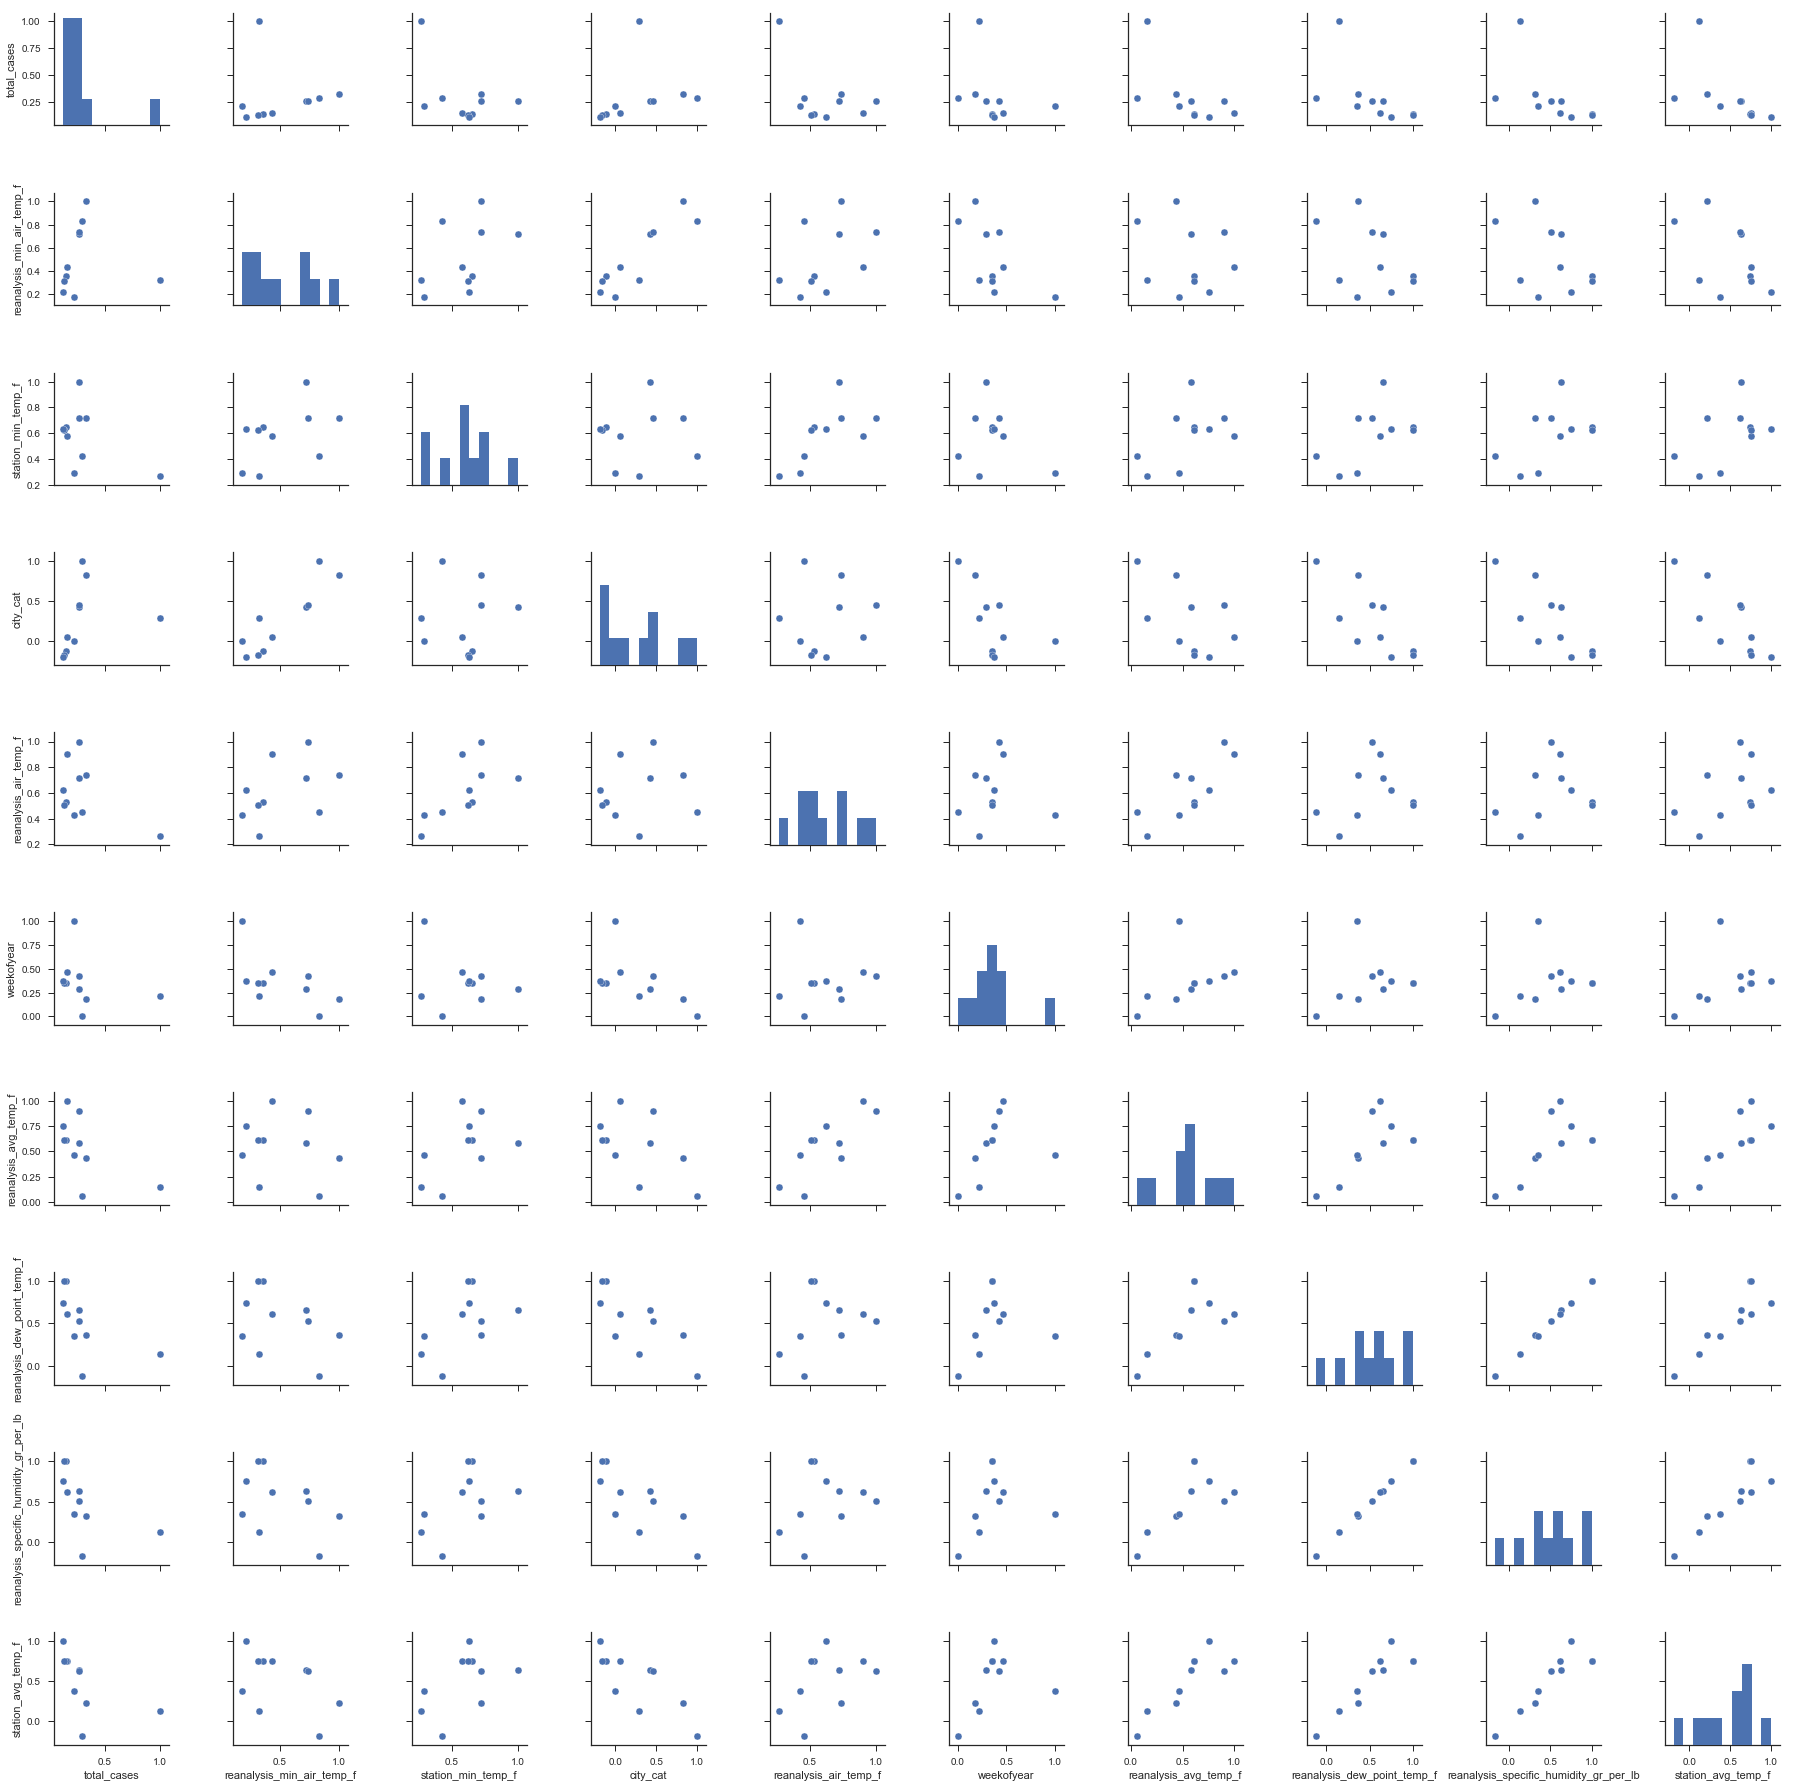

In [42]:
# All the positively correlated values with total cases. There are a few that have very closely fit lines while others are 
# extrememly scattered. Again, I think the graphs will change once the temperature conversations are done.
sns.pairplot(dengue[['total_cases', 'reanalysis_min_air_temp_f','station_min_temp_f','city_cat', 'reanalysis_air_temp_f',
                    'weekofyear', 'reanalysis_avg_temp_f', 'reanalysis_dew_point_temp_f', 
                     'reanalysis_specific_humidity_gr_per_lb','station_avg_temp_f']].corr())
None

In [43]:
# Relative humidity, expressed as a percent, measures the current absolute humidity relative to the maximum (highest point) for 
# that temperature. Specific humidity is the ratio of the mass of water vapor to the total mass of the moist air parcel.This was 
# taken from a website since I was trying to find a correlation between the two features.
# It's hard to compare these two values since they are different units of measure. They are related since they both have to do
# with degree of humidity. There is no clear relationship as a high percentage can have a lower humdity per grain per pound.
# I'm sure there are other factors that effect the humdity such as the amount of rain fall that particular day or the tempertaure
# since humidity usually does have a correlation with high tempertaures and the amount of water vapor in the air.
# I'm not sure how this would relate to mosquito growth. I belive tempertaure and actual amount of rain are better routes to take.
# I'm not going to get rid of the columns but I probably will not be using them as a predictive factor.
dengue[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_gr_per_lb']].head(10)

,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_gr_per_lb
0,73.365714,98.09
1,77.368571,107.61
2,82.052857,117.94
3,80.337143,116.71
4,80.460000,120.47
5,79.891429,120.49
6,82.000000,120.64
7,83.375714,125.84
8,82.768571,124.53
9,81.281429,126.50


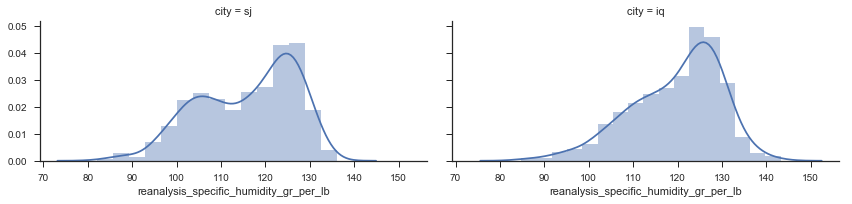

In [44]:
# The two cities are very similar in specific humidity which maybe an indicator as to why the mosquitoes are so prevelant there.
# Peru is slightly higher but both peak around the same point about 125 gr/lb.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(sns.distplot, "reanalysis_specific_humidity_gr_per_lb")
None

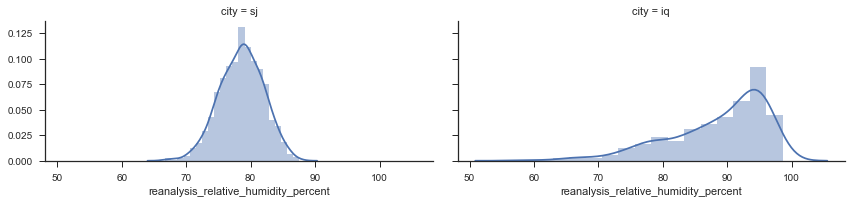

In [45]:
# Puerto Rico has a very normal distribution compared to Peru. This coudl be why Puerto Rico has a year round level of cases 
# while Peru definitly peaks at one point during the year and that is probably when the outbreaks are at their highest.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(sns.distplot, "reanalysis_relative_humidity_percent")
None

In [46]:
# The following are 9 columns that have NaN values for 10 rows. 
nans = dengue[['reanalysis_air_temp_f','reanalysis_avg_temp_f','reanalysis_dew_point_temp_f','reanalysis_max_air_temp_f',
        'reanalysis_min_air_temp_f','reanalysis_precip_amt_lb_per_in2','reanalysis_relative_humidity_percent',
        'reanalysis_specific_humidity_gr_per_lb','reanalysis_tdtr_f']]

In [47]:
nans[nans.isnull().any(axis=1)]
#nans[np.isnan(nans)]

,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_min_air_temp_f,reanalysis_precip_amt_lb_per_in2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_gr_per_lb,reanalysis_tdtr_f
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# These are the rows to be dropped. 
dengue.drop(87, inplace = True)
dengue.drop(139, inplace = True)
dengue.drop(399, inplace = True)
dengue.drop(451, inplace = True)
dengue.drop(711, inplace = True)
dengue.drop(763, inplace = True)
dengue.drop(1118, inplace = True)
dengue.drop(1170, inplace = True)
dengue.drop(1378, inplace = True)
dengue.drop(1430, inplace = True)

##### Analysis of 10 rows of NaN values

I could imputer or at least fillna but I don't see the benefit. I think having 0 would be more determinal to the data then keeping it. The data is spread over multiple years and seasons. I don't know what year or week each indexed row is. In order to accurately imputer the needed information I would have to go by year and week and imputer based on the seasonality. I think there comes a point where the amount of work to create data that for some unknown reason was never recorded becasue specious and a danger to the integrity of the the entire dataset. Due to these reasons I will be dropping these 10 rows.

In [49]:
# There are 189 NaN values. Trying to imputer these would be possible but with so many missing I dont know how accurate I would
# be since these are dependent on seasons and I woudl have to break down the data based on the seasons. I think this is like the 
# the rows that were dropped from before. It would be more harm to just imputer values that may or may not be accurate and yield
# vaild results. Instead I will drop the column. There are three others that have less null values and those I will work on 
# determining how to, the best of my ability, accurately imputer.
dengue.ndvi_ne.isnull().sum()

189

In [50]:
# Dropping column.
dengue.drop('ndvi_ne', axis = 1, inplace = True)

In [51]:
# Imputing the missing values
print(dengue['ndvi_nw'].describe())

print('Mode', mode(dengue['ndvi_nw']))

count    1399.000000
mean        0.130703
std         0.119981
min        -0.456100
25%         0.049350
50%         0.121314
75%         0.216863
max         0.454429
Name: ndvi_nw, dtype: float64
Mode ModeResult(mode=array([ 0.0278]), count=array([3]))


In [52]:
# Since the measurements have to deal with vegetation in an areas, I wanted to get a sense of what the timeframe of the year was
# this way I could more accurately pick a more accurate measurement. 
#dengue.ndvi_nw.sort_values(na_position='first').index()<0
#dengue.loc[dengue.ndvi_nw.index.isnull()]
dengue[np.isnan(dengue['ndvi_nw'])]

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
45,sj,1991,11,1991-03-12,NaN,0.213250,0.240543,78.138571,1,78.671429,89.06,69.08,48.148571,0.000000,0.000000,0.141732,72.59,75.706571,76.074286,68.334286,80.51,-454.758571,0.019017,103.51,17
62,sj,1991,28,1991-07-09,NaN,0.138050,0.167917,77.877143,1,83.145714,91.04,75.92,44.008571,0.241339,0.241339,0.181102,76.55,80.332571,80.638571,72.754571,84.11,-455.298571,0.026598,120.06,14
65,sj,1991,31,1991-07-30,NaN,0.190643,0.159329,81.897143,1,83.428571,91.94,77.00,43.417143,1.905906,1.905906,0.708661,77.27,80.065143,80.265714,73.991429,83.93,-455.530000,0.048914,125.15,25
67,sj,1991,33,1991-08-13,NaN,0.155100,0.156700,79.197143,1,84.971429,91.94,78.08,41.848571,0.000000,0.000000,0.129921,77.99,81.086000,81.500000,74.001714,85.37,-455.735714,0.029016,125.38,60
99,sj,1992,13,1992-03-25,NaN,0.134843,0.106800,80.238571,1,79.160000,89.96,71.96,42.285714,0.000000,0.000000,0.090551,72.77,75.323429,75.701429,68.771429,80.87,-454.630000,0.029869,104.78,29
108,sj,1992,22,1992-05-27,NaN,0.219157,0.213014,87.301429,1,81.371429,89.06,75.02,42.722857,7.332677,7.332677,3.157480,74.93,77.838286,78.080000,73.731714,82.85,-455.427143,0.185330,124.83,20
162,sj,1993,23,1993-06-11,NaN,0.153771,0.148486,80.615714,1,85.820000,93.92,77.00,45.294286,0.333858,0.333858,0.051181,77.63,81.515429,81.654286,74.891429,85.37,-454.912857,0.028731,129.44,12
181,sj,1993,42,1993-10-22,NaN,0.134700,0.149686,78.807143,1,82.760000,91.94,75.02,45.860000,0.000000,0.000000,0.251969,76.73,80.656571,80.767143,73.433429,84.65,-455.607143,0.024180,123.15,38
188,sj,1993,49,1993-12-10,NaN,0.163233,0.082833,80.302857,1,79.751429,87.08,69.98,44.754286,0.208268,0.208268,0.818898,74.21,77.123429,77.077143,70.466000,81.23,-455.427143,0.061729,111.53,31
191,sj,1994,52,1994-01-01,NaN,NaN,NaN,78.018571,1,80.548571,91.04,71.06,46.760000,0.206693,0.206693,0.011811,73.13,77.678857,78.131429,70.252571,82.13,-455.272857,0.004836,110.46,22


In [53]:
strategy = 'median' 

ndvinw_imputer = Imputer(strategy=strategy)
ndvinw_imputer.fit(dengue[['ndvi_nw']])

NWs = ndvinw_imputer.transform(
    dengue[['ndvi_nw']])
print(NWs[0:5], NWs.mean())
# Imputered the missing values and added them to the column.
dengue[['ndvi_nw']]=NWs

[[ 0.103725 ]
 [ 0.142175 ]
 [ 0.1729667]
 [ 0.2450667]
 [ 0.2622   ]] 0.130397627836


In [54]:
# Examining the missing  null values
dengue[np.isnan(dengue['ndvi_se'])]

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
191,sj,1994,52,1994-01-01,0.121314,NaN,NaN,78.018571,1,80.548571,91.04,71.06,46.760000,0.206693,0.206693,0.011811,73.13,77.678857,78.131429,70.252571,82.13,-455.272857,0.004836,110.46,22
229,sj,1994,38,1994-09-24,0.121314,NaN,NaN,79.314286,1,83.068571,89.96,75.92,43.134286,1.544094,1.544094,1.350394,76.91,80.124286,80.394286,73.060571,84.47,-456.095714,0.072112,121.48,302
230,sj,1994,39,1994-10-01,0.121314,NaN,NaN,80.372857,1,82.425714,93.02,73.94,44.060000,2.200000,2.200000,1.240157,76.19,79.445429,79.687143,72.808571,83.57,-454.990000,0.064289,120.74,395
231,sj,1994,40,1994-10-08,0.121314,NaN,NaN,74.117143,1,83.685714,93.92,75.92,44.420000,0.024803,0.024803,0.322835,77.99,81.008857,81.230000,71.983143,84.83,-454.938571,0.003983,117.21,426
232,sj,1994,41,1994-10-15,0.121314,NaN,NaN,78.225714,1,82.991429,95.00,75.02,45.782857,0.657480,0.657480,1.543307,76.37,79.679429,79.648571,72.196571,85.55,-454.758571,0.058031,118.30,461
233,sj,1994,42,1994-10-22,0.121314,NaN,NaN,76.348571,1,83.428571,95.00,75.02,45.397143,2.975197,2.975197,0.212598,77.27,80.759429,81.050000,72.564286,85.73,-454.218571,0.022487,119.87,381
234,sj,1994,43,1994-10-29,0.121314,NaN,NaN,85.417143,1,81.808571,91.04,73.94,45.088571,4.390551,4.390551,1.543307,75.83,78.190571,78.272857,73.438571,81.23,-456.687143,0.092238,123.49,333
235,sj,1994,44,1994-11-05,0.121314,NaN,NaN,78.685714,1,82.682857,89.96,75.92,44.317143,0.212992,0.212992,0.074803,77.27,80.090857,80.420000,72.852286,83.75,-455.478571,0.022188,120.85,353
236,sj,1994,45,1994-11-12,0.121314,NaN,NaN,80.095714,1,81.165714,89.06,71.96,44.471429,1.270079,1.270079,2.145669,75.29,79.064857,78.761429,72.374000,83.03,-455.658571,0.052057,118.89,410
237,sj,1994,46,1994-11-19,0.121314,NaN,NaN,83.584286,1,81.114286,91.04,71.96,45.165714,1.266535,1.266535,1.870079,75.83,78.887429,79.070000,73.443714,84.29,-456.481429,0.067561,123.51,364


In [55]:
# Imputing the missing values
print(dengue['ndvi_se'].describe())

print('Mode', mode(dengue['ndvi_se']))

count    1429.000000
mean        0.203845
std         0.073935
min        -0.015533
25%         0.155100
50%         0.196114
75%         0.248914
max         0.538314
Name: ndvi_se, dtype: float64
Mode ModeResult(mode=array([ 0.08821429]), count=array([2]))


In [56]:
strategy = 'median' 

ndvise_imputer = Imputer(strategy=strategy)
ndvise_imputer.fit(dengue[['ndvi_se']])

SEs = ndvise_imputer.transform(
    dengue[['ndvi_se']])
print(SEs[0:5], SEs.mean())
# Imputered the missing values and added them to the column.
dengue[['ndvi_se']]=SEs

[[ 0.1984833]
 [ 0.1623571]
 [ 0.1572   ]
 [ 0.2275571]
 [ 0.2512   ]] 0.203753929158


In [57]:
# Examining the missing null values
dengue[np.isnan(dengue['ndvi_sw'])]

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
191,sj,1994,52,1994-01-01,0.121314,0.196114,NaN,78.018571,1,80.548571,91.04,71.06,46.760000,0.206693,0.206693,0.011811,73.13,77.678857,78.131429,70.252571,82.13,-455.272857,0.004836,110.46,22
229,sj,1994,38,1994-09-24,0.121314,0.196114,NaN,79.314286,1,83.068571,89.96,75.92,43.134286,1.544094,1.544094,1.350394,76.91,80.124286,80.394286,73.060571,84.47,-456.095714,0.072112,121.48,302
230,sj,1994,39,1994-10-01,0.121314,0.196114,NaN,80.372857,1,82.425714,93.02,73.94,44.060000,2.200000,2.200000,1.240157,76.19,79.445429,79.687143,72.808571,83.57,-454.990000,0.064289,120.74,395
231,sj,1994,40,1994-10-08,0.121314,0.196114,NaN,74.117143,1,83.685714,93.92,75.92,44.420000,0.024803,0.024803,0.322835,77.99,81.008857,81.230000,71.983143,84.83,-454.938571,0.003983,117.21,426
232,sj,1994,41,1994-10-15,0.121314,0.196114,NaN,78.225714,1,82.991429,95.00,75.02,45.782857,0.657480,0.657480,1.543307,76.37,79.679429,79.648571,72.196571,85.55,-454.758571,0.058031,118.30,461
233,sj,1994,42,1994-10-22,0.121314,0.196114,NaN,76.348571,1,83.428571,95.00,75.02,45.397143,2.975197,2.975197,0.212598,77.27,80.759429,81.050000,72.564286,85.73,-454.218571,0.022487,119.87,381
234,sj,1994,43,1994-10-29,0.121314,0.196114,NaN,85.417143,1,81.808571,91.04,73.94,45.088571,4.390551,4.390551,1.543307,75.83,78.190571,78.272857,73.438571,81.23,-456.687143,0.092238,123.49,333
235,sj,1994,44,1994-11-05,0.121314,0.196114,NaN,78.685714,1,82.682857,89.96,75.92,44.317143,0.212992,0.212992,0.074803,77.27,80.090857,80.420000,72.852286,83.75,-455.478571,0.022188,120.85,353
236,sj,1994,45,1994-11-12,0.121314,0.196114,NaN,80.095714,1,81.165714,89.06,71.96,44.471429,1.270079,1.270079,2.145669,75.29,79.064857,78.761429,72.374000,83.03,-455.658571,0.052057,118.89,410
237,sj,1994,46,1994-11-19,0.121314,0.196114,NaN,83.584286,1,81.114286,91.04,71.96,45.165714,1.266535,1.266535,1.870079,75.83,78.887429,79.070000,73.443714,84.29,-456.481429,0.067561,123.51,364


In [58]:
# Imputing the missing values
print(dengue['ndvi_sw'].describe())

print('Mode', mode(dengue['ndvi_sw']))

count    1429.000000
mean        0.202489
std         0.083956
min        -0.063457
25%         0.144578
50%         0.189757
75%         0.247029
max         0.546017
Name: ndvi_sw, dtype: float64
Mode ModeResult(mode=array([ 0.1688714]), count=array([3]))


In [59]:
strategy = 'median' 

ndvisw_imputer = Imputer(strategy=strategy)
ndvisw_imputer.fit(dengue[['ndvi_sw']])

SWs = ndvise_imputer.transform(
    dengue[['ndvi_sw']])
print(SWs[0:5], SWs.mean())
# Imputered the missing values and added them to the column.
dengue[['ndvi_sw']]=SWs

[[ 0.1776167]
 [ 0.1554857]
 [ 0.1708429]
 [ 0.2358857]
 [ 0.24734  ]] 0.20241442899


##### Analysis on Imputing ndvi_ nulls
<h4> Two issues with imputing ndvi_nw,se,sw: 1. I wasn't happy that I couldn't give accurate accounts. The data for indicies 229-242, are at least all in the same year and season so the data I created shouldn't be too far off actually accounts. For the other years and especially for nw, which had many more null values, I'm concerned the data will be off.</h4>
<h4> 2. If I had more time to learn and experiment with manually creating the data by doing it by season I would have. But it comes to a point in a project, where a choice has to be made on whether to spend an exorbitant amount of time going through hundreds of rows and figuring out the data manually or just imputing the values and spend more time building a strong unbiased model.</h4>
<h4>I decide to spend the time working on the models and learning seaxonal decompose to try and accurately predict outbreaks other ways. I will keep these sets in mind when looking at data so I can remind myself that these data points were created and weren't actually recorded for one reason or another.</h4>

In [60]:
#dengue[np.isnan(dengue[['station_avg_temp_f','station_max_temp_f','station_min_temp_f','station_diur_temp_rng_f',
 #      'precipitation_amt_inch','reanalysis_sat_precip_amt_inch','station_precip_inch']])]
nans = dengue[['station_avg_temp_f','station_max_temp_f','station_min_temp_f','station_diur_temp_rng_f',
               'reanalysis_sat_precip_amt_inch','station_precip_inch']]

In [61]:
nans[nans.isnull().any(axis=1)]

,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,reanalysis_sat_precip_amt_inch,station_precip_inch
93,78.851429,89.96,68.00,43.828571,NaN,0.051181
94,78.362857,93.02,71.06,45.294286,NaN,0.350394
95,77.514286,84.92,71.06,43.108571,NaN,0.629921
957,81.860000,97.70,70.70,52.430000,2.201181,NaN
981,NaN,90.50,NaN,NaN,2.916535,0.000000
987,NaN,90.14,62.78,NaN,0.048031,1.220472
993,80.780000,92.30,64.04,53.915000,0.000000,NaN
1029,80.960000,94.28,68.54,55.400000,4.310630,NaN
1031,NaN,92.30,70.16,NaN,2.364173,0.039370
1047,NaN,91.58,69.44,NaN,1.248425,2.779528


In [62]:
# Imputing the missing values
print(dengue['station_min_temp_f'].describe())

print('Mode', mode(dengue['station_min_temp_f']))

count    1442.000000
mean       71.783870
std         2.833319
min        58.460000
25%        69.980000
50%        71.960000
75%        73.940000
max        78.080000
Name: station_min_temp_f, dtype: float64
Mode ModeResult(mode=array([ 75.02]), count=array([135]))


In [63]:
strategy = 'median' 

stamintemp_imputer = Imputer(strategy=strategy)
stamintemp_imputer.fit(dengue[['station_min_temp_f']])

SMTFs = stamintemp_imputer.transform(
    dengue[['station_min_temp_f']])
print(SMTFs[0:5], SMTFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_min_temp_f']]=SMTFs

[[ 68.  ]
 [ 71.96]
 [ 73.04]
 [ 73.94]
 [ 75.02]] 71.7843568465


In [64]:
# Imputing the missing values
print(dengue['reanalysis_sat_precip_amt_inch'].describe())

print('Mode', mode(dengue['reanalysis_sat_precip_amt_inch']))

count    1443.000000
mean        1.801590
std         1.721084
min         0.000000
25%         0.385827
50%         1.509449
75%         2.765157
max        15.377953
Name: reanalysis_sat_precip_amt_inch, dtype: float64
Mode ModeResult(mode=array([ 0.]), count=array([239]))


In [65]:
strategy = 'median' 

resaprep_imputer = Imputer(strategy=strategy)
resaprep_imputer.fit(dengue[['reanalysis_sat_precip_amt_inch']])

RSPAIs = resaprep_imputer.transform(
    dengue[['reanalysis_sat_precip_amt_inch']])
print(RSPAIs[0:5], RSPAIs.mean())
# Imputered the missing values and added them to the column.
dengue[['reanalysis_sat_precip_amt_inch']]=RSPAIs

[[ 0.48897638]
 [ 0.8984252 ]
 [ 1.35984252]
 [ 0.60472441]
 [ 0.29606299]] 1.8009839797


In [66]:
# Imputing the missing values
print(dengue['station_max_temp_f'].describe())

print('Mode', mode(dengue['station_max_temp_f']))

count    1436.000000
mean       90.414387
std         3.526773
min        80.060000
25%        87.980000
50%        91.040000
75%        93.020000
max       107.960000
Name: station_max_temp_f, dtype: float64
Mode ModeResult(mode=array([ 91.04]), count=array([146]))


In [67]:
strategy = 'median' 

stamaxtemp_imputer = Imputer(strategy=strategy)
stamaxtemp_imputer.fit(dengue[['station_max_temp_f']])

STFs = stamaxtemp_imputer.transform(
    dengue[['station_max_temp_f']])
print(STFs[0:5], STFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_max_temp_f']]=STFs

[[ 84.92]
 [ 89.06]
 [ 89.96]
 [ 91.94]
 [ 95.  ]] 90.4187136929


In [68]:
# Imputing the missing values
print(dengue['station_precip_inch'].describe())

print('Mode', mode(dengue['station_precip_inch']))

count    1434.000000
mean        1.548282
std         1.868319
min         0.000000
25%         0.342520
50%         0.938976
75%         2.122047
max        21.389764
Name: station_precip_inch, dtype: float64
Mode ModeResult(mode=array([ 0.]), count=array([42]))


In [69]:
strategy = 'median' 

staprein_imputer = Imputer(strategy=strategy)
staprein_imputer.fit(dengue[['station_precip_inch']])

SPIs = staprein_imputer.transform(
    dengue[['station_precip_inch']])
print(SPIs[0:5], SPIs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_precip_inch']]=SPIs

[[ 0.62992126]
 [ 0.33858268]
 [ 1.62992126]
 [ 0.15748031]
 [ 0.22834646]] 1.54322540595


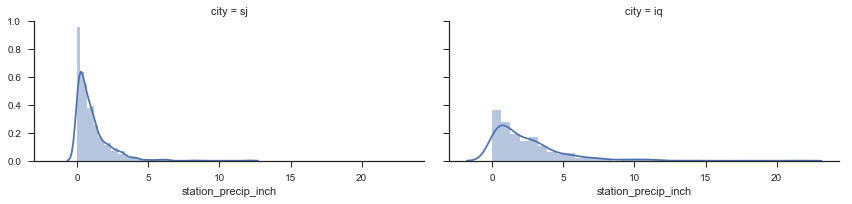

In [70]:
# Puerto Rico has much more rain then Peru but Peru seems to have a more constant amount. Interesting, it's the oppoiste of 
# the humidity graphs.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(sns.distplot, "station_precip_inch")
None

In [71]:
# Imputing the missing values
print(dengue['station_avg_temp_f'].describe())

print('Mode', mode(dengue['station_avg_temp_f']))

count    1413.000000
mean       80.934410
std         2.326225
min        70.520000
25%        79.340000
50%        81.345714
75%        82.682857
max        87.440000
Name: station_avg_temp_f, dtype: float64
Mode ModeResult(mode=array([ 81.32]), count=array([17]))


In [72]:
strategy = 'median' 

statemp_imputer = Imputer(strategy=strategy)
statemp_imputer.fit(dengue[['station_avg_temp_f']])

SATFs = statemp_imputer.transform(
    dengue[['station_avg_temp_f']])
print(SATFs[0:5], SATFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_avg_temp_f']]=SATFs

[[ 77.79714285]
 [ 80.08571428]
 [ 80.08571428]
 [ 81.44857143]
 [ 84.09714285]] 80.9437966803


In [73]:
# Imputing the missing values
print(dengue['station_diur_temp_rng_f'].describe())

print('Mode', mode(dengue['station_diur_temp_rng_f']))

count    1413.000000
mean       46.506790
std         3.831422
min        40.151429
25%        43.725714
50%        45.140000
75%        49.220000
max        60.440000
Name: station_diur_temp_rng_f, dtype: float64
Mode ModeResult(mode=array([ 43.13428571]), count=array([14]))


In [74]:
strategy = 'median' 

stadtemp_imputer = Imputer(strategy=strategy)
stadtemp_imputer.fit(dengue[['station_diur_temp_rng_f']])

SDTRFs = stadtemp_imputer.transform(
    dengue[['station_diur_temp_rng_f']])
print(SDTRFs[0:5], SDTRFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_diur_temp_rng_f']]=SDTRFs

[[ 44.42      ]
 [ 43.46857143]
 [ 43.67428571]
 [ 44.18857143]
 [ 48.86857143]] 46.4755981031


In [75]:
# This column is being dropped becasue it has the same values as reanalysis_sat_precip_amt_inch. I decided to drop this column
# over the other becasue this is the only column from a single sourced data set. The other column is coming from data set with
# multiple other features which are all scaled the same. The scaling is different for the column being dropped, so it makes 
#sense to drop this column instead of the one from the group.
dengue.drop('precipitation_amt_inch', axis = 1, inplace = True)

In [76]:
# I decided to drop this column becasue its a reanalysis of a column alrady in the dataset and that column makes more sense
# then this one. They are scaled differently and this one, once converted from Kelvin to Farenheit, didn't make sense anymore
# and I was concerned it would cause more harm then good for my data set. Also, the range of tempature difference throughout the
# day shouldn't make a difference unless its a large one, as in a range of 50 or more degrees, and that rarely happens in nature.
dengue.drop('reanalysis_tdtr_f', axis =1, inplace = True)

In [77]:
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,city_cat,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
0,sj,1990,18,1990-04-30,0.103725,0.198483,0.177617,73.365714,1,77.797143,84.92,68.00,44.420000,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,0.045515,98.09,4
1,sj,1990,19,1990-05-07,0.142175,0.162357,0.155486,77.368571,1,80.085714,89.06,71.96,43.468571,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,0.025517,107.61,5
2,sj,1990,20,1990-05-14,0.172967,0.157200,0.170843,82.052857,1,80.085714,89.96,73.04,43.674286,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,0.037123,117.94,4
3,sj,1990,21,1990-05-21,0.245067,0.227557,0.235886,80.337143,1,81.448571,91.94,73.94,44.188571,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,0.019770,116.71,3
4,sj,1990,22,1990-05-28,0.262200,0.251200,0.247340,80.460000,1,84.097143,95.00,75.02,48.868571,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,0.017352,120.47,6


In [78]:
# Created a column that shows the rate in change between weeks in total cases.
#dengue['change'] = dengue.total_cases.pct_change()
dengue['change_in_cases'] = dengue['total_cases'].diff(1)
dengue = dengue.fillna(0)

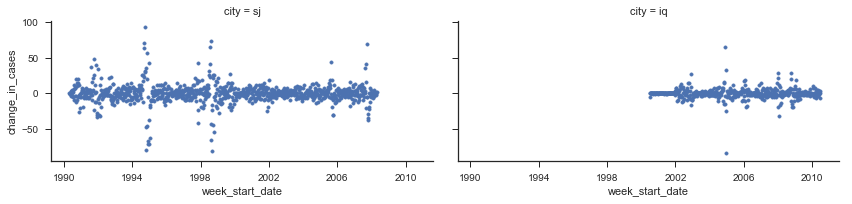

In [79]:
figsize = (25, 20)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(plt.scatter,"week_start_date", "change_in_cases", marker=".")
None

## 4. Preprocessing

#### Spliting the Data set, Train_Test_Split, Scaling, and Baseline

In [80]:
# Setting up separate data sets for each city.
dengue_sj = dengue[dengue.city=='sj'].copy()
dengue_iq = dengue[dengue.city=='iq'].copy()

In [81]:
# Checking shape and info for each new data set. Each set has been cleaned and though the San Juan set has more data, the data
# in both sets is complete and is ready for modeling.
print("San Juan dataset", dengue_sj.shape)
print("San Juan dataset", dengue_sj.info())
print("Iquitos dataset", dengue_iq.shape)
print("Iquitos dataset", dengue_iq.info())

San Juan dataset (930, 24)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 935
Data columns (total 24 columns):
city                                      930 non-null object
year                                      930 non-null int64
weekofyear                                930 non-null int64
week_start_date                           930 non-null datetime64[ns]
ndvi_nw                                   930 non-null float64
ndvi_se                                   930 non-null float64
ndvi_sw                                   930 non-null float64
reanalysis_relative_humidity_percent      930 non-null float64
city_cat                                  930 non-null int64
station_avg_temp_f                        930 non-null float64
station_max_temp_f                        930 non-null float64
station_min_temp_f                        930 non-null float64
station_diur_temp_rng_f                   930 non-null float64
reanalysis_sat_precip_amt_inch            930 non

In [93]:
# X and y values for San Juan set
Xsj = dengue_sj[[col for col in dengue_sj if 'total_cases' not in col]]
ysj = dengue_sj.total_cases

In [94]:
# Train test split initiated for San Juan set
Xsj_train, Xsj_test, ysj_train, ysj_test = train_test_split(Xsj, ysj, random_state = 42,test_size =.50 )

In [95]:
# X and y values for Iquitos set
Xiq = dengue_iq[[col for col in dengue_iq if 'total_cases' not in col]]
yiq = dengue_iq.total_cases

In [96]:
# Train test split initiated for Inquitos set
Xiq_train, Xiq_test, yiq_train, yiq_test = train_test_split(Xiq, yiq, random_state = 42,test_size =.50 )

In [97]:
# Scaling will be put in the pipeline so I'm not going to do it here; it will be in the next section.
# I will be using Standard Scalar

In [130]:
# Creating baseline based on MSE
# create y pred for ysj
y_pred1 = ysj_train.mean()
dengue["y_pred1"] = ysj_train.mean()
# create y pred for yiq
y_pred2 = yiq_train.mean()
dengue["y_pred2"] = yiq_train.mean()
# set up y true for ysj and yiq
#y_true1 = ysj_train
#y_true2 = yiq_train

In [131]:
# creating y pred for both citied.
y_pred1 = np.ones(len(ysj_train)) * ysj_train.mean()
y_pred2 = np.ones(len(yiq_train)) * yiq_train.mean()

y_pred = np.append(y_pred1,y_pred2)

In [132]:
y_true = np.append(ysj_train,yiq_train)

In [133]:
# Created Baseline for model
mean_squared_error(y_true, y_pred)

1912.9045135073536

#### Summary of Observations and Next Steps

## 5. Modeling

*** SVC with Gradient Boosting Regressor in pipeline..... Seasonality time series modeling***

### 5. a. Regression Model 

#### Summary of Results

### 5. b. Timeseries Model

#### Summary of Results

## 6. Test Data set

In [88]:
#Loaded dengue test csv files
dengue_test = pd.read_csv('dengue_features_test.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 6. a. Modeling

#### Summary of Results

### 6. b. Predictions

#### Summary of Results

### 6. c. Submission

# Capstone Summary: Observations, Discoveries, Pitfalls, and Future Steps